## Gene Expression RNA-Seq Classification 

#### Data Processing, Normalization, and Correlation

This dataset contains two data files. One file contains the sample numbers and names. The othe file contains our RNA-Seq data set that shows the gene expression levels of ~20,000 genes for each samples. 

From this data set, I will explore different classification models and see which model can accurately predict tumors based on certain gene expression levels. 

This dataset only contains information on these tumors:
- BRCA
- KIRC
- COAD
- LUAD 
- PRAD

**Pipeline:**
- Clean up our data to remove any significant genes expression, such as columns containing all zero values
- Normalize our data to be comparable with each other
- Create a clustering model to explore our data in depth 
- Test out multiple classification models with different test groups and numbers and compare their accuracy

### Load Data

In [1]:
# Import packages

# Initial Packages
import pandas as pd
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter

# Categorical to Numeric
from sklearn.preprocessing import LabelEncoder

# SMOTE for imbalanced data
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle


# Normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
# Files 
data_file = "/Users/kim/Desktop/repos/RNA-Seq_GeneExpression_Model/Datasets/data.csv"
labels_file = "/Users/kim/Desktop/repos/RNA-Seq_GeneExpression_Model/Datasets/labels.csv"
# Load data
data_df = pd.read_csv(data_file)
labels_df = pd.read_csv(labels_file)

In [3]:
# Check out our data
print(data_df.head())
print(labels_df.head())

  Unnamed: 0  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5  \
0   sample_0     0.0  2.017209  3.265527  5.478487  10.431999     0.0   
1   sample_1     0.0  0.592732  1.588421  7.586157   9.623011     0.0   
2   sample_2     0.0  3.511759  4.327199  6.881787   9.870730     0.0   
3   sample_3     0.0  3.663618  4.507649  6.659068  10.196184     0.0   
4   sample_4     0.0  2.655741  2.821547  6.539454   9.738265     0.0   

     gene_6    gene_7  gene_8  ...  gene_20521  gene_20522  gene_20523  \
0  7.175175  0.591871     0.0  ...    4.926711    8.210257    9.723516   
1  6.816049  0.000000     0.0  ...    4.593372    7.323865    9.740931   
2  6.972130  0.452595     0.0  ...    5.125213    8.127123   10.908640   
3  7.843375  0.434882     0.0  ...    6.076566    8.792959   10.141520   
4  6.566967  0.360982     0.0  ...    5.996032    8.891425   10.373790   

   gene_20524  gene_20525  gene_20526  gene_20527  gene_20528  gene_20529  \
0    7.220030    9.119813   12.003135  

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [5]:
# Check if there's any null values in both of our dataframe
print_columns_with_null(data_df)
print_columns_with_null(labels_df)

No columns have null values.
No columns have null values.


In [6]:
# Merge the two dataframes together
merged_df = pd.merge(data_df, labels_df, on = 'Unnamed: 0', how = 'inner')
merged_df

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000,PRAD
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000,LUAD
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000,PRAD
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000,PRAD
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000,BRCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,...,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000,BRCA
797,sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,...,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000,LUAD
798,sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,...,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693,COAD
799,sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,...,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000,PRAD


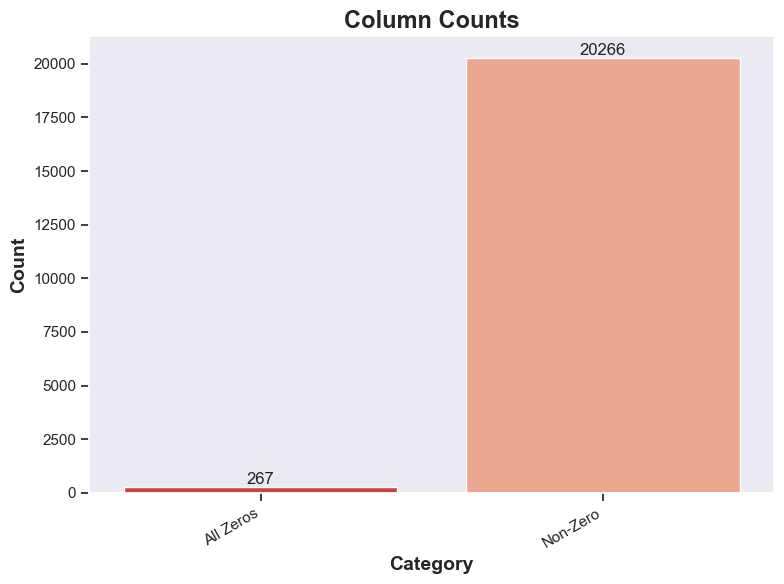

In [7]:
# From seeing bits of our data, we see some columns completely have all 0 values. Let's check how many columns have all zero values and columns with atleast one non-zero values

# Print out the count of columns with all zero values and atleast one non-zero values
Columns_counts_df = count_columns_with_zeros(merged_df)

# Visualize using a bar plot

# Setting up figure settings
sns.set(style="dark", font="sans serif")
fig_dims = (8, 6)

# Create the bar graph
f, (ax) = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x = 'Category', y = 'Count',
                data = Columns_counts_df,
                palette='Reds_r',
                ax=ax)

# Set up labels
plt.xlabel('Category', fontsize=14, loc= 'center', fontweight = 'bold');
plt.ylabel('Count', fontsize=14, loc= 'center', fontweight = 'bold');
plt.title('Column Counts', fontsize=17, fontweight = 'bold')

# Add ticks to both x and y axis
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Put bar labels on each bars
for container in ax.containers:
    ax.bar_label(container, size = 12)

# Format graph 
f.autofmt_xdate()
plt.tight_layout()
plt.show()

In [8]:
# Drop all columns with all zero values
updated_df = remove_cols_with_all_zero(merged_df)
updated_df.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


### Testing:
From the printed dataframe, there are some columns with 0 zeros and I want to make sure that there are actual non-zero values in the columns. So, I will do a test with column 2 ('gene_0') to see if my remove_cols_with_all_zero function worked. 


In [9]:
# Assign the second column to a variable 
second_column = updated_df['gene_0']

# Check if there are any non-zero values in the second column
any_non_zero_values = (second_column != 0).any()

# Print the result
print(f"Are there any non-zero values in the second column? {any_non_zero_values}")

Are there any non-zero values in the second column? True


In [10]:
# Add all the non-zero values into a list
non_zero_values = second_column[second_column != 0].tolist()

# Print the list of non-zero values
print("Non-zero values in the second column:")
print(non_zero_values)

Non-zero values in the second column:
[0.341758085079, 0.631523406479, 1.48233202075, 0.66775590841, 0.544089666549, 0.81893234401, 0.412944073369, 0.531867995606, 0.328721595402, 0.34164424053, 0.565889584403, 0.698840770207, 0.624709202229, 0.588900487699, 1.21915302835, 0.487383443037, 0.337539842197, 0.547745938687, 1.24110797493, 0.873340751556, 0.757450016231, 0.646439185614, 0.566669050913, 0.542010355537, 0.844064214792, 0.553163870509, 0.450379880071, 0.283921772308, 0.664118707339, 0.325156117742, 0.363339311629, 0.807767061766, 0.408603179343, 0.404031139622, 0.43658829366]


From this, we saw that there are non-zero values in our second column which means that our function worked.

### Check the distribution of the tumor classes.
This is beneficial to check to see if our dataset we will be training our model is imbalanced

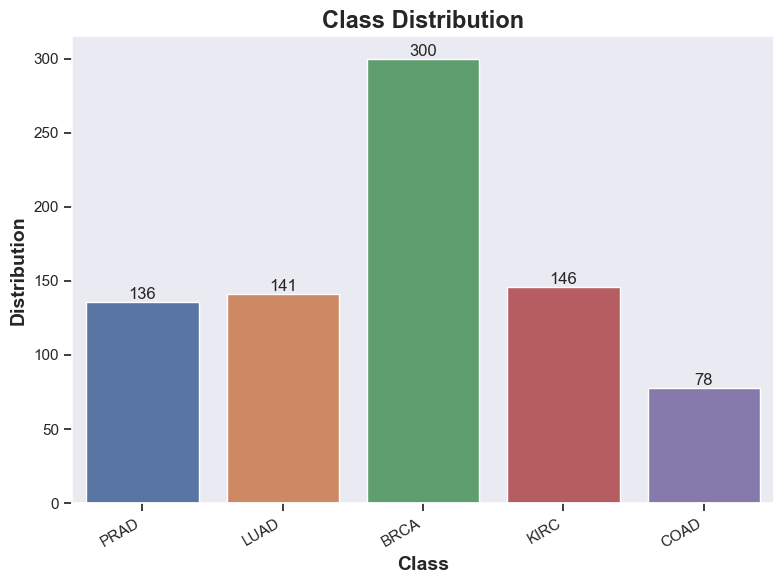

In [11]:
# Count # of classes 
class_distribution = Counter(updated_df['Class'])
class_column_names = ['Class', 'Distribution']
class_dist_df = dict_to_df(class_distribution, class_column_names)
class_dist_df

# Visualize using a bar plot

# Setting up figure settings
sns.set(style="dark", font="sans serif")
fig_dims = (8, 6)

# Create the bar graph
f, (ax) = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x = 'Class', y = 'Distribution',
                data = class_dist_df,
                palette='deep',
                ax=ax)

# Set up labels
plt.xlabel('Class', fontsize=14, loc= 'center', fontweight = 'bold');
plt.ylabel('Distribution', fontsize=14, loc= 'center', fontweight = 'bold');
plt.title('Class Distribution', fontsize=17, fontweight = 'bold')

# Add ticks to both x and y axis
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Put bar labels on each bars
for container in ax.containers:
    ax.bar_label(container, size = 12)

# Format graph 
f.autofmt_xdate()
plt.tight_layout()
plt.show()

In [12]:
# Assuming your DataFrame is named 'df'


# Extract features (X) and target variable (y)
X = updated_df.drop(['Unnamed: 0','Class'], axis=1)  # Drop non-feature columns
y = updated_df['Class']

# Apply SMOTE to generate synthetic samples
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Class'] = y_resampled

# Shuffle the DataFrame
df_resampled_shuffled = shuffle(df_resampled, random_state=42)

# Shift this column to the third column
last_column = df_resampled_shuffled.iloc[:,-1]
df_resampled_shuffled = df_resampled_shuffled.drop(df_resampled_shuffled.columns[-1], axis = 1)
df_resampled_shuffled.insert(0, last_column.name, last_column)

# Count the occurrences of each class in the shuffled DataFrame
resampled_distribution = df_resampled_shuffled['Class'].value_counts()

# Print the resampled DataFrame
print(df_resampled_shuffled)

/var/folders/fj/1bp6c_7s3b51sm954hmfznt40000gn/T/ipykernel_28793/502661675.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['Class'] = y_resampled


     Class    gene_0    gene_1    gene_2    gene_3     gene_4    gene_6  \
1116  KIRC  0.053131  2.185391  2.129093  6.374629   9.551359  5.981269   
1368  PRAD  0.000000  0.870955  3.010615  7.078216  10.104074  6.654744   
422   BRCA  0.000000  4.122805  2.939922  6.730137   9.508001  6.959306   
413   PRAD  0.000000  3.926882  4.990551  6.562079   8.970868  7.722753   
451   BRCA  0.000000  2.543372  2.564476  6.299157   9.783317  7.105542   
...    ...       ...       ...       ...       ...        ...       ...   
1130  KIRC  0.000000  1.776256  2.643057  6.047797  10.132871  7.719507   
1294  LUAD  0.000000  4.468543  4.617051  6.815985   9.311741  8.081579   
860   COAD  0.000000  2.923804  3.602580  7.662982   9.745030  8.181426   
1459  PRAD  0.807538  1.973383  3.421670  6.032660  10.683836  7.844231   
1126  KIRC  0.000000  1.993169  2.547753  6.991716   9.275809  8.215209   

        gene_7  gene_8  gene_9  ...  gene_20521  gene_20522  gene_20523  \
1116  0.000000     0.0  

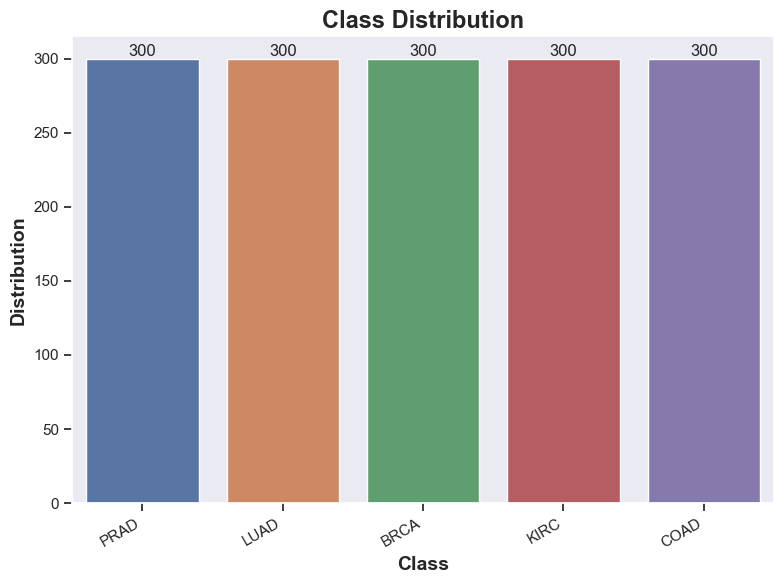

In [13]:
# Check our the count of each classes in the balanced dataset
class_distribution_resampled = Counter(df_resampled['Class'])
class_column_names= ['Class', 'Distribution']
resampled_distribution_df = dict_to_df(class_distribution_resampled, class_column_names)
resampled_distribution_df

# Visualize using a bar plot

# Setting up figure settings
sns.set(style="dark", font="sans serif")
fig_dims = (8, 6)

# Create the bar graph
f, (ax) = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x = 'Class', y = 'Distribution',
                data = resampled_distribution_df,
                palette='deep',
                ax=ax)

# Set up labels
plt.xlabel('Class', fontsize=14, loc= 'center', fontweight = 'bold');
plt.ylabel('Distribution', fontsize=14, loc= 'center', fontweight = 'bold');
plt.title('Class Distribution', fontsize=17, fontweight = 'bold')

# Add ticks to both x and y axis
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# Put bar labels on each bars
for container in ax.containers:
    ax.bar_label(container, size = 12)

# Format graph 
f.autofmt_xdate()
plt.tight_layout()
plt.show()

In [14]:
# Encoder
LE = LabelEncoder()

# Fit the encoder and transform the data
df_resampled_shuffled['class_encoded'] = LE.fit_transform(df_resampled_shuffled['Class'])

# Shift this column to the third column
last_column = df_resampled_shuffled.iloc[:,-1]
df_resampled_shuffled = df_resampled_shuffled.drop(df_resampled_shuffled.columns[-1], axis = 1)
df_resampled_shuffled.insert(1, last_column.name, last_column)
df_resampled_shuffled

,Class,class_encoded,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
1116,KIRC,2,0.053131,2.185391,2.129093,6.374629,9.551359,5.981269,0.000000,0.0,...,6.082999,8.448775,9.958614,4.297722,10.256597,11.956406,10.192791,9.106968,5.701753,0.049595
1368,PRAD,4,0.000000,0.870955,3.010615,7.078216,10.104074,6.654744,0.000000,0.0,...,4.679887,8.025320,9.559705,5.069546,10.141775,13.193550,10.049186,8.888535,7.460064,0.000000
422,BRCA,0,0.000000,4.122805,2.939922,6.730137,9.508001,6.959306,0.845109,0.0,...,6.704111,9.459323,10.705149,6.782736,10.622290,11.136222,10.787837,10.416871,8.318724,0.000000
413,PRAD,4,0.000000,3.926882,4.990551,6.562079,8.970868,7.722753,0.443607,0.0,...,6.131768,8.759436,10.207222,5.534824,10.008779,11.233823,10.250073,9.933233,5.343422,0.000000
451,BRCA,0,0.000000,2.543372,2.564476,6.299157,9.783317,7.105542,1.443448,0.0,...,6.682967,9.629983,10.355946,7.365832,9.374287,11.050787,10.296698,10.552400,5.411399,0.363564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,KIRC,2,0.000000,1.776256,2.643057,6.047797,10.132871,7.719507,0.325400,0.0,...,5.297159,8.212336,9.625056,3.287073,9.612343,12.268147,9.629786,9.321581,4.270199,0.000000
1294,LUAD,3,0.000000,4.468543,4.617051,6.815985,9.311741,8.081579,0.569611,0.0,...,5.642629,8.445557,11.134638,2.305562,9.907993,11.777109,10.511230,9.419296,6.456342,0.390899
860,COAD,1,0.000000,2.923804,3.602580,7.662982,9.745030,8.181426,0.006949,0.0,...,6.178705,9.072101,10.181527,0.003924,9.247646,12.365738,11.175087,9.752405,3.611730,0.000000
1459,PRAD,4,0.807538,1.973383,3.421670,6.032660,10.683836,7.844231,0.048950,0.0,...,5.045668,7.995329,9.605593,6.954292,8.837062,11.297516,9.618031,9.160208,7.597883,0.000000


In [15]:
# Take out 20% of data (300) to be used to validate classification models
val_data = df_resampled_shuffled.tail(300).copy()
df_resampled_shuffled.drop(df_resampled_shuffled.tail(300).index, inplace = True)
df_resampled_shuffled

,Class,class_encoded,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
1116,KIRC,2,0.053131,2.185391,2.129093,6.374629,9.551359,5.981269,0.000000,0.0,...,6.082999,8.448775,9.958614,4.297722,10.256597,11.956406,10.192791,9.106968,5.701753,0.049595
1368,PRAD,4,0.000000,0.870955,3.010615,7.078216,10.104074,6.654744,0.000000,0.0,...,4.679887,8.025320,9.559705,5.069546,10.141775,13.193550,10.049186,8.888535,7.460064,0.000000
422,BRCA,0,0.000000,4.122805,2.939922,6.730137,9.508001,6.959306,0.845109,0.0,...,6.704111,9.459323,10.705149,6.782736,10.622290,11.136222,10.787837,10.416871,8.318724,0.000000
413,PRAD,4,0.000000,3.926882,4.990551,6.562079,8.970868,7.722753,0.443607,0.0,...,6.131768,8.759436,10.207222,5.534824,10.008779,11.233823,10.250073,9.933233,5.343422,0.000000
451,BRCA,0,0.000000,2.543372,2.564476,6.299157,9.783317,7.105542,1.443448,0.0,...,6.682967,9.629983,10.355946,7.365832,9.374287,11.050787,10.296698,10.552400,5.411399,0.363564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,BRCA,0,0.000000,4.018705,3.364194,6.870722,10.625152,4.585311,0.585059,0.0,...,6.129640,9.241151,9.771849,8.019952,9.578733,10.372136,9.350194,10.047478,3.644191,0.000000
157,PRAD,4,0.000000,3.981743,3.781926,6.403283,10.190430,8.770182,0.695281,0.0,...,6.528748,9.132811,10.916312,6.995767,10.015499,10.353279,10.581455,9.819837,3.127617,0.000000
1195,LUAD,3,0.000000,4.253635,3.998080,6.695440,9.124381,6.935065,0.282826,0.0,...,6.318251,8.888750,10.604995,1.445600,10.004742,11.021987,10.686573,9.263103,5.219202,0.000000
16,LUAD,3,0.000000,3.460913,3.618474,5.661048,9.731217,8.435591,1.033652,0.0,...,5.350285,8.197320,9.907260,0.763921,10.088854,11.471137,9.768648,9.170596,2.932118,0.000000


In [16]:
# Save dataframe to a csv file
subfolder_path = "/Users/kim/Desktop/repos/RNA-Seq_GeneExpression_Model/Datasets"
csv_filename_val = "Model Validation DataSet.csv"
csv_filename_orig = "Balanced DataSet.csv"
save_dataframe_to_csv(val_data, subfolder_path, csv_filename_val)
save_dataframe_to_csv(df_resampled_shuffled, subfolder_path, csv_filename_orig)

In [17]:
# Check our the count of each classes in the balanced dataset
df_resampled_class = Counter(df_resampled_shuffled['Class'])
class_column_names= ['Class', 'Distribution']
resampled_class_df = dict_to_df(df_resampled_class, class_column_names)
resampled_class_df

,Class,Distribution
0,KIRC,242
1,PRAD,238
2,BRCA,246
3,COAD,249
4,LUAD,225


In [18]:
# Check our the count of each classes in the balanced dataset
val_class_count = Counter(val_data['Class'])
class_column_names= ['Class', 'Distribution']
val_class_df = dict_to_df(val_class_count, class_column_names)
val_class_df

,Class,Distribution
0,BRCA,54
1,PRAD,62
2,LUAD,75
3,COAD,51
4,KIRC,58


Next Step: 

Normalize both dataframes 
1. resampled_class_df
2. val_class_df

Save the normalized dataframes to the subfolder

Create 2 different sub dataframes based on the correlation to the 'Class' target variable
- This will be used to train our classification modeling 